In [49]:
%matplotlib inline
import sys
sys.path.append('/Users/pradap/Documents/Research/Python-Package/anhaid/py_entitymatching/')

![title](workflow.png)

In [50]:
# py_entitymatching relies on the following packages from the Python eco-system

|S.No|  Package | Comments  |
|---|---|---|
|1|  *pandas*  | provides data structures (such as DataFrame) to <span style="color:red;">store and manage relational data</span>. Specifically, DataFrame is used to represent input tables.  |
|2| *scikit-learn*   | provides implementations for common <span style="color:red;">machine learning</span> algorithms. Specifically, this is used in ML-based matchers.  |
|3| *joblib*  | provides <span style="color:red;">multiprocessing</span> capabilities. Specifically, this is used to parallelize blockers across multiple processors.|
|4| *PyQt4*  | provides tools to <span style="color:red;">build GUI</span>. Specifically, this is used to build GUI for labeling data  and debugging matchers.|
|5|  *py_stringsimjoin* |  provides <span style="color:red;">scalable</span> implementations for <span style="color:red;">string similarity joins</span> over two tables. Specifically,   this is used to scale blockers. |
|6| *py_stringmatching* | provides a comprehensive set of <span style="color:red;"> tokenizers and string similarity functions</span>. Specifically, this is to create features for blocking and matching.|
|7|  *cloudpickle* |provides functions to <span style="color:red;"> serialize Python constructs</span>. Specifically, this is used to load/save objects from/to disk. |
|8| *pyprind*  | library to display <span style="color:red;"> progress indicators</span>. Specifically, this is used to display progress of blocking functions, matching functions, etc.  |
|9| *pyparsing*  | library to <span style="color:red;">parse strings</span>. Specifically, this is used to parse rules/features that are declaratively written by the user.  |
|10|  *six* |  provides functions to <span style="color:red;">write compatible code across Python 2 and 3</span>. |

In [51]:
import py_entitymatching as em
import profiler
import pandas as pd

## Read input tables

In [54]:
## Read input tables
A = em.read_csv_metadata('dblp_demo.csv', key='id')
B = em.read_csv_metadata('acm_demo.csv', key='id')

In [53]:
len(A), len(B), len(A) * len(B)

(1800, 1813, 3263400)

In [55]:
A.head(2)

,id,title,authors,venue,year
0,l0,Paradise: A Database System for GIS Applications,Paradise Team,SIGMOD Conference,1995
1,l1,A Query Language and Optimization Techniques for Unstructured Data,"Gerd G. Hillebrand, Peter Buneman, Susan B. Davidson, Dan Suciu",SIGMOD Conference,1996


In [56]:
B.head(2)

,id,title,authors,venue,year
0,r0,An efficient bitmap encoding scheme for selection queries,"Chee-Yong Chan, Yannis E. Ioannidis",International Conference on Management of Data,1999
1,r1,Integrating a Structured-Text Retrieval System with an Object-Oriented Database System,"Tak W. Yan, Jurgen Annevelink",Very Large Data Bases,1994


In [58]:
# If the tables are large we can downsample the tables like this
A1, B1 = em.down_sample(A, B, 500, 1, show_progress=False)
len(A1), len(B1)

# But for the demo, we will use the entire table A and B

(477, 500)

## Block tables to get candidate set

Number of unique values: 10
Number of missing values: 0

Unique values:
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003]

Frequency plot:



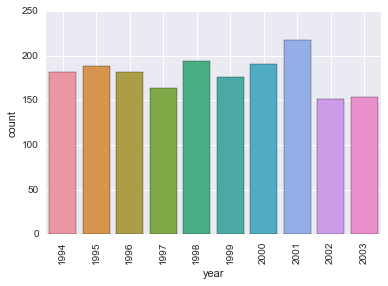

In [59]:
profiler.profile_table(A, 'year')

Number of unique values: 11
Number of missing values: 0

Unique values:
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 20003]

Frequency plot:



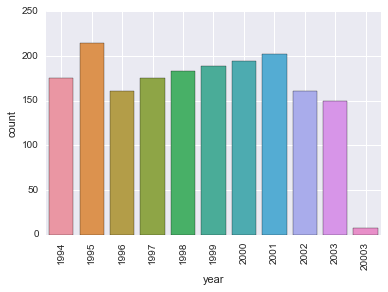

In [60]:
profiler.profile_table(B, 'year')

In [61]:
B.replace({'year':{
            20003:2003
        }}, inplace=True)

![title](profile_table.png)

In [62]:
### Blocking plan

### A, B -- AttrEquivalence blocker [year]--------------------------| Candidate set

In [63]:
# Create attribute equivalence blocker
ab = em.AttrEquivalenceBlocker()
# Block tables using 'year' attribute : same year include in candidate set
C1 = ab.block_tables(A, B, 'year', 'year', 
                     l_output_attrs=['title', 'authors', 'year'],
                     r_output_attrs=['title', 'authors', 'year']
                    )
len(C1)

328781

In [64]:
C1.head(2)

,_id,ltable_id,rtable_id,ltable_title,ltable_authors,ltable_year,rtable_title,rtable_authors,rtable_year
0,0,l0,r2,Paradise: A Database System for GIS Applications,Paradise Team,1995,Nearest neighbor queries,"Nick Roussopoulos, Stephen Kelley, Frédéric Vincent",1995
1,1,l0,r3,Paradise: A Database System for GIS Applications,Paradise Team,1995,The LyriC language: querying constraint objects,"Alexander Brodsky, Yoram Kornatzky",1995


### Debug blocking output

In [65]:
# check whether the current blocking method has dropped a lot of potential matches
dbg = em.debug_blocker(C1, A, B, 
                       l_output_attrs=['title', 'authors', 'year'], 
                       r_output_attrs=['title', 'authors', 'year'])

In [67]:
dbg.head()

,_id,similarity,ltable_id,rtable_id,ltable_title,ltable_authors,ltable_year,rtable_title,rtable_authors,rtable_year
0,0,0.941176,l239,r821,Workshop Report on Experiences Using Object Data Management in the Real-World,Akmal B. Chaudhri,1998,Workshop report on experiences using object data management in the real-world,Akmal B. Chaudhri,1999
1,1,0.941176,l941,r94,"Some Remarks on Variable Independence, Closure, and Orthographic Dimension in Constraint Databases",Leonid Libkin,1999,"Some remarks on variable independence, closure, and orthographic dimension in constraint databases",Leonid Libkin,1998
2,2,0.928571,l790,r106,Research in database engineering at the University of Namur,Jean-Luc Hainaut,2003,Research in database engineering at the University of Namur,Jean-Luc Hainaut,2002
3,3,0.928571,l1039,r1051,Middle East Technical University Software Research and Development Center,Asuman Dogac,1996,Middle East Technical University Software Research and Development Center,Asuman Dogac,1998
4,4,0.923077,l1207,r148,Database Research at NTHU and ITRI,Arbee L. P. Chen,1994,Database research at NTHU and ITRI,Arbee L. P. Chen,1995


In [17]:
# em.view_table(dbg)

In [68]:
# Revised blocking plan

# A, B -- AttrEquivalence blocker [year] --------------------|
#                                                           |---> candidate set
# A, B -- Overlap blocker [title]---------------------------|

In [19]:
profiler.profile_table(A, 'title', plot=False)

,Property,Value
0,Num. Missing Values,0
1,Num. Unique Values,1797
2,List of Unique Values,"[1-Safe Algorithms for Symmetric Site Configurations, 3D Geographic Network Displays, 50,000 Use..."


In [20]:
profiler.profile_table(B, 'title', plot=False)

,Property,Value
0,Num. Missing Values,0
1,Num. Unique Values,1803
2,List of Unique Values,"[1-Safe Algorithms for Symmetric Site Configurations, 2Q: A Low Overhead High Performance Buffer..."


In [69]:
# Initialize overlap blocker
ob = em.OverlapBlocker()
# Block over title attribute
C2 = ob.block_tables(A, B, 'title', 'title', show_progress=False, overlap_size=1)
len(C2)

476319

In [70]:
# Combine the outputs from attr. equivalence blocker and overlap blocker
C = em.combine_blocker_outputs_via_union([C1, C2])
len(C)

752550

In [71]:
# Check again to see if we are dropping any potential matches
dbg = em.debug_blocker(C, A, B, 
                       l_output_attrs=['title', 'authors', 'year'], 
                       r_output_attrs=['title', 'authors', 'year'])


In [72]:
dbg.head()

,_id,similarity,ltable_id,rtable_id,ltable_title,ltable_authors,ltable_year,rtable_title,rtable_authors,rtable_year
0,0,0.400000,l188,r1666,An Early Look at XQuery,"Andrew Eisenberg, Jim Melton",2002,Standards in practice,"Andrew Eisenberg, Jim Melton",1998
1,1,0.400000,l1686,r1666,SQL/XML is Making Good Progress,"Andrew Eisenberg, Jim Melton",2002,Standards in practice,"Andrew Eisenberg, Jim Melton",1998
2,2,0.400000,l484,r1666,SQL Standardization: The Next Steps,"Andrew Eisenberg, Jim Melton",2000,Standards in practice,"Andrew Eisenberg, Jim Melton",1998
3,3,0.384615,l519,r352,Developments at ACM TODS,Richard T. Snodgrass,2003,Reminiscences in influential papers,Richard Snodgrass,1998
4,4,0.384615,l519,r921,Developments at ACM TODS,Richard T. Snodgrass,2003,Reminiscences on influential papers,Richard Snodgrass,1998


### Match tuple pairs in candidate set

#### 1. Sample candidate set  --> S
#### 2. Label S 
#### 3. Split S into development set (I) and evaluation set (J)
#### 4. Select best learning-based matcher X, using I
#### 5. Compute accuracy of X on J

In [73]:
# Sample  candidate set
S = em.sample_table(C, 450)

In [74]:
# Label S
S = em.label_table(S, 'label')

In [75]:
# Load the pre-labeled data
S = em.read_csv_metadata('labeled_data_demo.csv', ltable=A, rtable=B)
len(S)

450

In [76]:
# Split S into I an J
IJ = em.split_train_test(S, train_proportion=0.7, random_state=0)
I = IJ['train']
J = IJ['test']

### Selecting the best learning-based matcher using I


#### 1. Create a set of ML-matchers
#### 2. Generate a set of features (F)
#### 3. Convert I into a set of feature vectors (H) using F
#### 4. Select best learning-based matcher (X) using k-fold cross validation over H
#### 5. Debug X (and repeat the above steps)

In [77]:
# Create a set of ML-matchers
dt = em.DTMatcher(name='DecisionTree', random_state=0)
svm = em.SVMMatcher(name='SVM', random_state=0)
rf = em.RFMatcher(name='RF', random_state=0)
lg = em.LogRegMatcher(name='LogReg', random_state=0)
ln = em.LinRegMatcher(name='LinReg')

In [78]:
# Generate a set of features
F = em.get_features_for_matching(A, B)

In [79]:
# List the feature names generated
F['feature_name']

0                              id_id_lev_dist
1                               id_id_lev_sim
2                                   id_id_jar
3                                   id_id_jwn
4                                   id_id_exm
5                       id_id_jac_qgm_3_qgm_3
6                 title_title_jac_qgm_3_qgm_3
7         title_title_cos_dlm_dc_sp_dlm_dc_sp
8                             title_title_mel
9                        title_title_lev_dist
10                        title_title_lev_sim
11            authors_authors_jac_qgm_3_qgm_3
12    authors_authors_cos_dlm_dc_sp_dlm_dc_sp
13                        authors_authors_mel
14                   authors_authors_lev_dist
15                    authors_authors_lev_sim
16                venue_venue_jac_qgm_3_qgm_3
17        venue_venue_cos_dlm_dc_sp_dlm_dc_sp
18        venue_venue_jac_dlm_dc_sp_dlm_dc_sp
19                            venue_venue_mel
20                       venue_venue_lev_dist
21                        venue_ve

In [80]:
# Convert the I into a set of feature vectors using F
H = em.extract_feature_vecs(I, 
                            feature_table=F, 
                            attrs_after='label',
                            show_progress=False) 

In [81]:
# Select the best ML matcher using CV
result = em.select_matcher([dt, rf, svm, ln, lg], table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=5,
        target_attr='label', metric='f1', random_state=0)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x1161179e8>,5,0.871795,0.820513,0.979592,0.979592,0.936170,0.917532
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x116117b00>,5,0.918919,0.944444,0.956522,1.000000,0.977778,0.959533
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x116117c50>,5,0.727273,0.848485,0.736842,0.956522,0.900000,0.833824
3,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x116117e10>,5,0.857143,0.944444,0.956522,1.000000,1.000000,0.951622
4,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x116117b38>,5,0.871795,0.871795,0.956522,1.000000,0.976744,0.935371


#### Debug X (Random Forest)

In [82]:
# Split H into P and Q
PQ = em.split_train_test(H, train_proportion=0.5, random_state=0)
P = PQ['train']
Q = PQ['test']

In [83]:
# Debug RF matcher using GUI
em.vis_debug_rf(rf, P, Q, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        target_attr='label')

In [36]:
# Swap P and Q, and debug again
em.vis_debug_rf(rf, Q, P, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        target_attr='label')

In [84]:
# Add a feature to do Jaccard on title + authors and add it to F

# Create a feature declaratively
sim = em.get_sim_funs_for_matching()
tok = em.get_tokenizers_for_matching()
feature_string = """jaccard(wspace((ltuple['title'] + ' ' + ltuple['authors']).lower()), 
                            wspace((rtuple['title'] + ' ' + rtuple['authors']).lower()))"""
feature = em.get_feature_fn(feature_string, sim, tok)

# Add feature to F
em.add_feature(F, 'jac_ws_title_authors', feature)

True

In [38]:
# Print supported sim. functions
pd.DataFrame({'simfunctions':sorted(sim.keys())})

,simfunctions
0,abs_norm
1,affine
2,cosine
3,dice
4,exact_match
5,hamming_dist
6,hamming_sim
7,jaccard
8,jaro
9,jaro_winkler


In [39]:
# Print supported tokenizers
pd.DataFrame({'tokenizers':sorted(tok.keys())})

,tokenizers
0,alphabetic
1,alphanumeric
2,dlm_dc_sp
3,qgm_2
4,qgm_3
5,wspace


In [85]:
F['feature_name']

0                              id_id_lev_dist
1                               id_id_lev_sim
2                                   id_id_jar
3                                   id_id_jwn
4                                   id_id_exm
5                       id_id_jac_qgm_3_qgm_3
6                 title_title_jac_qgm_3_qgm_3
7         title_title_cos_dlm_dc_sp_dlm_dc_sp
8                             title_title_mel
9                        title_title_lev_dist
10                        title_title_lev_sim
11            authors_authors_jac_qgm_3_qgm_3
12    authors_authors_cos_dlm_dc_sp_dlm_dc_sp
13                        authors_authors_mel
14                   authors_authors_lev_dist
15                    authors_authors_lev_sim
16                venue_venue_jac_qgm_3_qgm_3
17        venue_venue_cos_dlm_dc_sp_dlm_dc_sp
18        venue_venue_jac_dlm_dc_sp_dlm_dc_sp
19                            venue_venue_mel
20                       venue_venue_lev_dist
21                        venue_ve

In [86]:
# Convert I into feature vectors using updated F
H = em.extract_feature_vecs(I, 
                            feature_table=F, 
                            attrs_after='label',
                            show_progress=False) 

In [87]:
# Check whether the updated F improves X (Random Forest)
result = em.select_matcher([rf], table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=5,
        target_attr='label', metric='f1', random_state=0)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x116117b00>,5,0.918919,0.972973,0.978723,1.0,1.0,0.974123


In [88]:
# Select the best matcher again using CV
result = em.select_matcher([dt, rf, svm, ln, lg], table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=5,
        target_attr='label', metric='f1', random_state=0)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x1161179e8>,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x116117b00>,5,0.918919,0.972973,0.978723,1.000000,1.000000,0.974123
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x116117c50>,5,0.727273,0.848485,0.736842,0.956522,0.900000,0.833824
3,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x116117e10>,5,0.974359,1.000000,1.000000,1.000000,1.000000,0.994872
4,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x116117b38>,5,0.871795,0.871795,0.978723,1.000000,0.976744,0.939811


### Compute accuracy of X (Decision Tree) on J

#### 1. Train X using  H
#### 2. Convert J into a set of feature vectors (L)
#### 3. Predict on L using X
#### 4. Evaluate the predictions

In [89]:
# Train using feature vectors from I 
dt.fit(table=H, 
       exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'], 
       target_attr='label')

# Convert J into a set of feature vectors using F
L = em.extract_feature_vecs(J, feature_table=F,
                            attrs_after='label', show_progress=False)

# Predict on L 
predictions = dt.predict(table=L, exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'], 
              append=True, target_attr='predicted', inplace=False)

In [90]:
# Evaluate the predictions
eval_result = em.eval_matches(predictions, 'label', 'predicted')
em.print_eval_summary(eval_result)

Precision : 100.0% (40/40)
Recall : 100.0% (40/40)
F1 : 100.0%
False positives : 0 (out of 40 positive predictions)
False negatives : 0 (out of 95 negative predictions)


In [46]:
# Final workflow

![title](workflow.png)